# <center>Network Science</center>

## <center>Home Assignment #2: Network models</center>

### <center>Student: Denis Smirnov</center>

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Problems

### Task 1

Consider Barabasi and Albert dynamical grow model. Two main ingredients of this model are *network growing* and *prefferential attachment*. Implement two restricted B&A-based models:
<br \>

**Model A**
<br \>
Lack of prefferential attachment, that is at each time-step form edges uniformly at random while network keeps growing.

**Model B**
<br \>
Lack of growing, that is fix total number of nodes, on each time-step randomly choose one and form edges with prefferential attachment.
<br \>

1. Generate networks according to the models above ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
4. Is scale-free property conserved in these models?

Analyse results with respect to various parameter settings

In [2]:
def gen_model_A(n, m, n0 = 5):
    if n <= n0:
        raise ValueError('n should be bigger than n0')
    if m > n0:
        raise ValueError('m should not be bigger than n0')
    # initial links can be chosen arbitrarily, 
    # but each node must have at least 1 link 
    G = nx.complete_graph(n0) 
    for node in xrange(n0 + 1, n + 1):
        attach_to = np.random.choice(G.nodes(), m, 
                                     replace=False)
        G.add_node(node)
        for next_attach in attach_to:
            G.add_edge(node, next_attach)
    return G

In [3]:
def gen_model_B(n, m, t_max):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for t in xrange(t_max):
        node = np.random.choice(G.nodes(), 1)[0]
        nodelist = G.nodes()
        nodelist.remove(node)
        
        k_node = G.degree()[node]
        k_sum_adj = 2*G.number_of_edges()+ n-1 - k_node
        degree_cached = G.degree()
        # prbability of connection is proportional to degree+1,
        # since initially all degrees are 0 
        probs = [(degree_cached[i]+1.)/k_sum_adj for i in nodelist] 
        
        connect_to = np.random.choice(nodelist, m, p=probs)
        for c in connect_to:
            G.add_edge(node, c)
    return G

In [4]:
n = 2000
m = 5

model_A = gen_model_A(n, m)
model_B_tn = gen_model_B(n, m, t_max=n)
model_B_t5n = gen_model_B(n, m, t_max=5*n)

In [5]:
def prepare_pdf_cdf(degrees, total_number_of_nodes):
    degree_distr = np.array(
        sorted(degrees.values(), reverse=True))
    deg_freq = np.bincount(
        degree_distr).astype(np.float) / total_number_of_nodes
    cumulative_freq = np.cumsum(deg_freq)
    axis_index = np.arange(0, len(deg_freq))
    return (axis_index, deg_freq, cumulative_freq)

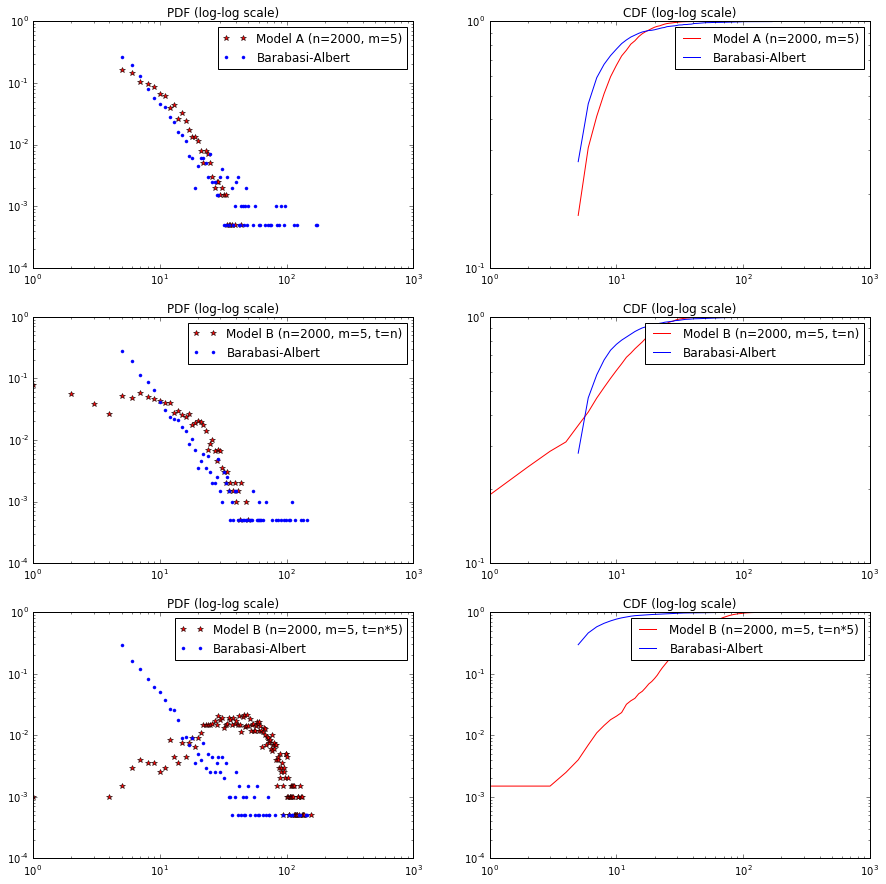

In [6]:
models = {
    'Model A (n=2000, m=5)' : model_A,
    'Model B (n=2000, m=5, t=n)' : model_B_tn,
    'Model B (n=2000, m=5, t=n*5)' : model_B_t5n
}

n_models = len(models)
fig, ax = plt.subplots(n_models, 2, figsize=(15, 5 * n_models))
row_num = 0

for model_name in sorted(models.keys()):
    model = models.get(model_name)
    (model_axis_ind, model_deg_freq, model_cumulative_freq) = \
        prepare_pdf_cdf(model.degree(), model.number_of_nodes())
    
    barabasi = nx.barabasi_albert_graph(
        model.number_of_nodes(),
        m) 
    (bar_axis_ind, bar_deg_freq, bar_cumulative_freq) = \
        prepare_pdf_cdf(barabasi.degree(), barabasi.number_of_nodes())
    
    model_pdf, = ax[row_num, 0].loglog(model_axis_ind, 
                                      model_deg_freq, 
                                      '*', c ='r',
                                      label=model_name)
    barabasi_pdf, = ax[row_num, 0].loglog(bar_axis_ind, 
                                         bar_deg_freq, 
                                         '.',
                                         label='Barabasi-Albert')
    
    model_cdf, = ax[row_num, 1].loglog(model_axis_ind, 
                                      model_cumulative_freq, 
                                      c='r',
                                      label=model_name)
    barabasi_cdf, = ax[row_num, 1].loglog(bar_axis_ind, 
                                      bar_cumulative_freq, 
                                      label='Barabasi-Albert')
    
    ax[row_num, 0].legend(handles=[model_pdf, barabasi_pdf])
    ax[row_num, 1].legend(handles=[model_cdf, barabasi_cdf])
    ax[row_num, 0].set_title('PDF (log-log scale)')
    ax[row_num, 1].set_title('CDF (log-log scale)')
    row_num +=1

In [7]:
def avg_path_and_clustering(model, arg_list):
    avg_path_length = np.array([])
    avg_clustering_coeff = np.array([])
    number_of_nodes = range(50, 500, 2)
    for n in number_of_nodes:
        g = max(nx.connected_component_subgraphs(
                model(n, *arg_list)), key=len)
        avg_path_length = np.append(avg_path_length,
            nx.average_shortest_path_length(g))
        avg_clustering_coeff = \
            np.append(avg_clustering_coeff,
                nx.average_clustering(g))
    return (number_of_nodes, 
            avg_path_length, 
            avg_clustering_coeff)

def plot_path_length_and_clustering(model, arg_list, title):
    (number_of_nodes, 
     avg_path_length, 
     avg_clustering_coeff) = \
        avg_path_and_clustering(model, arg_list)
    
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(number_of_nodes, avg_path_length)
    ax[0].set_title('Avg. path length')
    ax[1].plot(number_of_nodes, avg_clustering_coeff)
    ax[1].set_title('Avg. clustering coefficient')
    fig.suptitle(title)
    

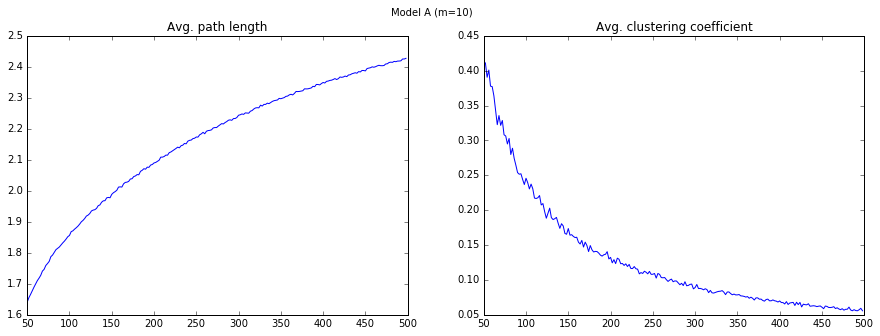

In [8]:
plot_path_length_and_clustering(gen_model_A, [10, 10], 'Model A (m=10)')

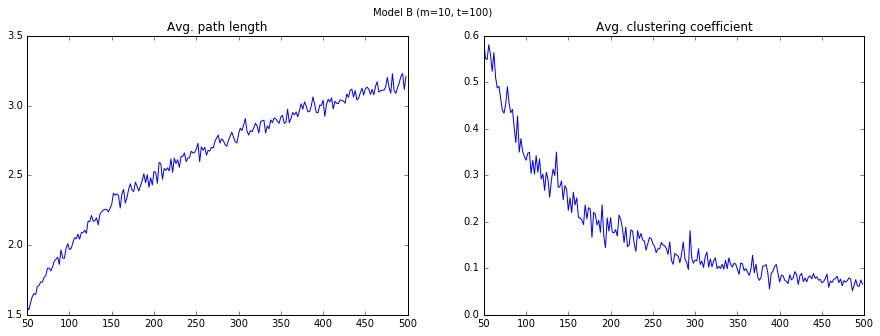

In [9]:
def gen_model_b_fixed_t(n, m):
    return gen_model_B(n, m, 100)
plot_path_length_and_clustering(gen_model_b_fixed_t, [10], 'Model B (m=10, t=100)')

In [10]:
def model_a_avg_degree(n, m, n0 = 5):
    if n <= n0:
        raise ValueError('n should be bigger than n0')
    if m > n0:
        raise ValueError('m should not be bigger than n0')
    G = nx.complete_graph(n0) 
    avg_degree = np.array([])
    for node in xrange(n0 + 1, n + 1):
        attach_to = np.random.choice(G.nodes(), m, 
                                     replace=False)
        G.add_node(node)
        for next_attach in attach_to:
            G.add_edge(node, next_attach)
        avg_degree = np.append(avg_degree,
            np.average(G.degree().values()))  
    return avg_degree

def model_b_avg_degree(n, m, t_max):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    avg_degree = np.array([])
    for t in xrange(t_max):
        node = np.random.choice(G.nodes(), 1)[0]
        nodelist = G.nodes()
        nodelist.remove(node)
        
        k_node = G.degree()[node]
        k_sum_adj = 2*G.number_of_edges()+ n-1 - k_node
        degree_cached = G.degree()
        # prbability of connection is proportional to degree+1,
        # since initially all degrees are 0 
        probs = [(degree_cached[i]+1.)/k_sum_adj for i in nodelist] 
        
        connect_to = np.random.choice(nodelist, m, p=probs)
        for c in connect_to:
            G.add_edge(node, c)
        avg_degree = np.append(avg_degree,
            np.average(G.degree().values()))  
    return avg_degree

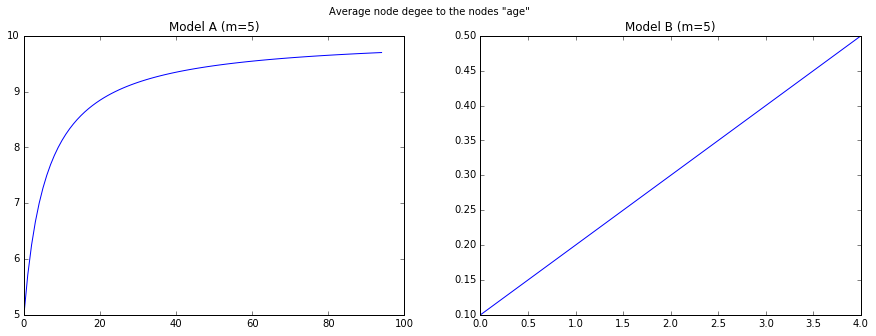

In [11]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(model_a_avg_degree(100, 5, 5))
ax[0].set_title('Model A (m=5)')

ax[1].plot(model_b_avg_degree(100, 5, 5)) 
ax[1].set_title('Model B (m=5)')
fig.suptitle('Average node degee to the nodes "age"')

**Neither model A, nor model B conserves scale-free property.**

Because of lack of preferential attachment in model A, all nodes create connections with equal probability. Node degree distiribution is exponential, so there is no possibility for appearing hubs with high degree.

Lack of growth in model B means that the number of nodes is fixed, which leads to linear growth of average node degree. For $ t\rightarrow \frac{N(N-1)}{2}$, network becomes a complete graph.


### <hr /> Task 2
Consider the following  "Vertex copying model" of growing network.

At every time step a random vertex from already existing vertices is selected and duplicated together with all edges, such that  every edge of the  vertex
* is copied with probability $q$
* is rewired to any other randomly selected vertex with probability $1-q$


Starting state is defined by some small number of randomly connected vertices.

The model can generate both directed and undirected networks.

1. Generate  graphs based on the model ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
    
Analyse results with respect to various parameter settings

In [12]:
import copy

def gen_vertex_copying(n, q, source):
    if source.number_of_nodes() >= n:
        raise ValueError('n is less than number of nodes in source graph')
    if q < 0 or q > 1:
        raise ValueError('q must be between 0 and 1')
    G = copy.deepcopy(source)
    for t in xrange(G.number_of_nodes(), n+1):
        node = np.random.choice(G.nodes())
        neighbors = G.neighbors(node)
        others = filter(lambda x: x not in neighbors,
                        G.nodes())
        G.add_node(t)
        for neighbor in neighbors:
            if np.random.random() <= q:
                G.add_edge(t, neighbor)
            else:
                G.add_edge(t, np.random.choice(others))
    return G 

In [13]:
source = nx.erdos_renyi_graph(25, .5)

vc_graph_01 = gen_vertex_copying(2000, .1, source)
vc_graph_05 = gen_vertex_copying(2000, .5, source)
vc_graph_09 = gen_vertex_copying(2000, .9, source)

In [14]:
def plot_pdf_cdf(G, title):
    (axis_ind, deg_freq, cumulative_freq) = \
        prepare_pdf_cdf(G.degree(), G.number_of_nodes())

    fig, ax = plt.subplots(1,2, figsize=(15,5))

    ax[0].loglog(axis_ind, deg_freq, '.')
    ax[1].loglog(axis_ind, cumulative_freq)

    ax[0].set_title('PDF (log-log scale)')
    ax[1].set_title('CDF (log-log scale)')
    fig.suptitle(title)

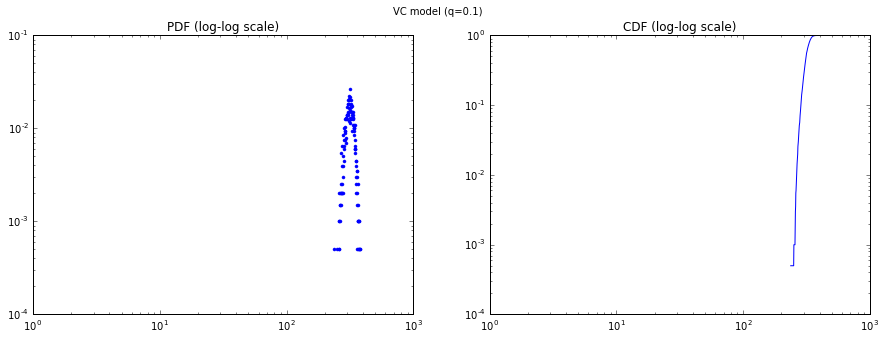

In [15]:
plot_pdf_cdf(vc_graph_01, 'VC model (q=0.1)')

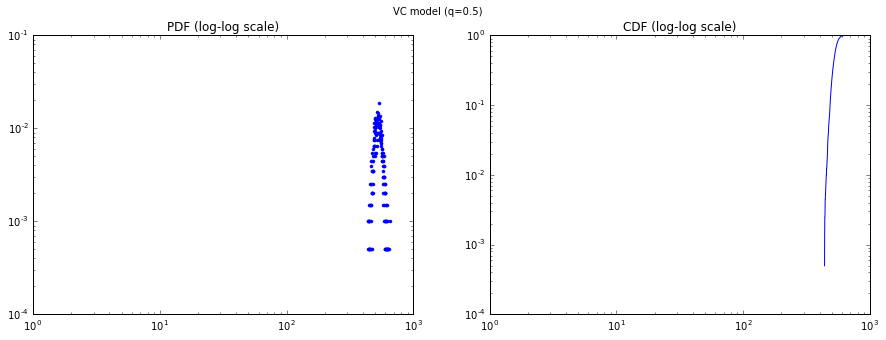

In [16]:
plot_pdf_cdf(vc_graph_05, 'VC model (q=0.5)')

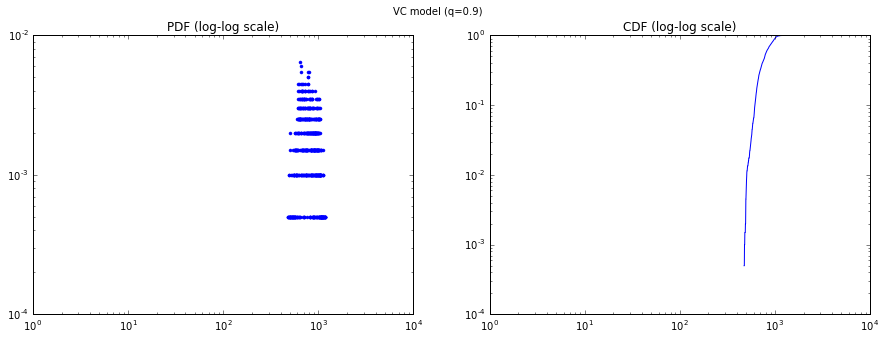

In [17]:
plot_pdf_cdf(vc_graph_09, 'VC model (q=0.9)')

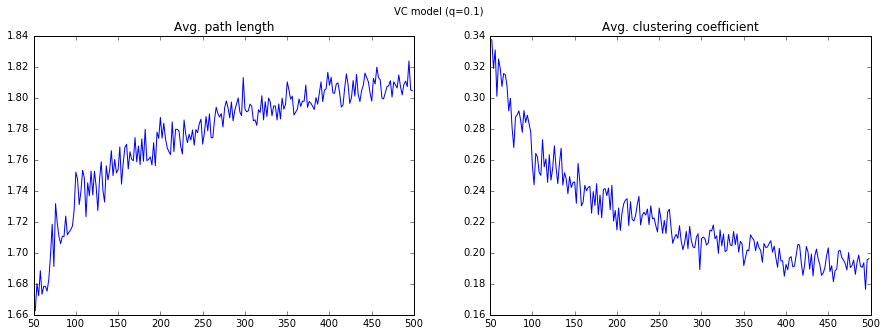

In [18]:
plot_path_length_and_clustering(gen_vertex_copying, [.1, source], 'VC model (q=0.1)')

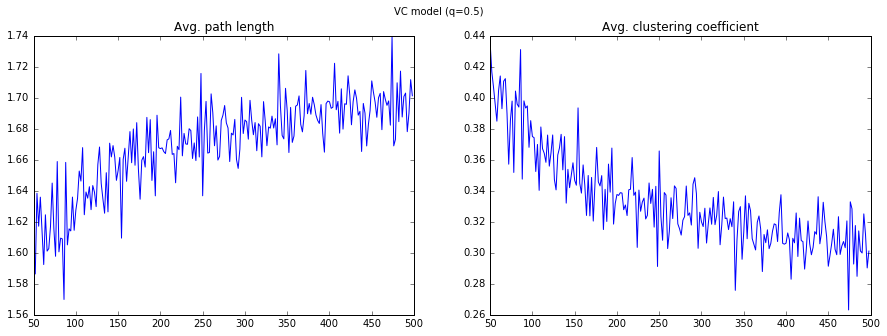

In [20]:
plot_path_length_and_clustering(gen_vertex_copying, [.5, source], 'VC model (q=0.5)')

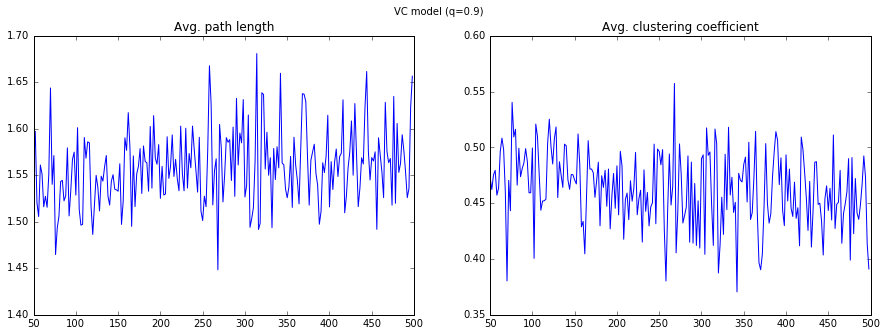

In [19]:
plot_path_length_and_clustering(gen_vertex_copying, [.9, source], 'VC model (q=0.9)')

In [21]:
def vertex_copying_avg_degree(n, q, source):
    if source.number_of_nodes() >= n:
        raise ValueError('n is less than number of nodes in source graph')
    if q < 0 or q > 1:
        raise ValueError('q must be between 0 and 1')
    G = copy.deepcopy(source)
    avg_degree = np.array([])
    for t in xrange(G.number_of_nodes(), n+1):
        node = np.random.choice(G.nodes())
        neighbors = G.neighbors(node)
        others = filter(lambda x: x not in neighbors,
                        G.nodes())
        G.add_node(t)
        for neighbor in neighbors:
            if np.random.random() <= q:
                G.add_edge(t, neighbor)
            else:
                G.add_edge(t, np.random.choice(others))
        avg_degree = np.append(avg_degree,
            np.average(G.degree().values()))  
    return avg_degree

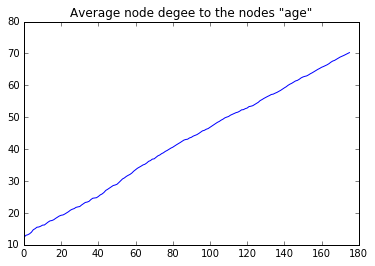

In [23]:
plt.plot(vertex_copying_avg_degree(200, .5, source))
plt.title('Average node degee to the nodes "age"')

In the process of growth, the nodes with higher degree will more probably increase their degree, because the more neigbors they have, the more probably their connection will be copied. This is especially true for large values of q. This process is similar to preferential attachment.

The difference from preferential attachment is that copying edges results in greater clustering coefficients, as  the node that was copied keeps some connections with neighbors of the original node.